In [2]:
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.applications import vgg19
from keras import Model
from keras import Input
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, Activation, BatchNormalization, MaxPooling2D
from keras.metrics import Mean
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import seaborn as sns
from IPython.display import clear_output
from matplotlib import pyplot as plt
import glob
import cv2
from tqdm import tqdm

# Load Images

In [3]:
def data_gen(img_paths, target_size):
    while True:
        for img in img_paths:
            img = keras.utils.load_img(img, target_size=target_size)
            img = np.asarray(img)/255
            img = np.expand_dims(img, 0)
            
            yield img
            
def load_imgs(img_paths, target_size):
    imgs = np.zeros((len(img_paths), target_size[0], target_size[1], 3))
    for i, img in enumerate(img_paths):
            img = keras.utils.load_img(img, target_size=target_size)
            img = np.asarray(img)/255
            img = np.expand_dims(img, 0)
            imgs[i] = img
    
    return imgs

# Make Autoencoder

The variational autoencoder consists of an encoder and a decoder. The decoder maps an input to the mean and (log) variance of a Gaussian distribution. After sampling a point from the distribution, the decoder then attempts to reconstruct the input from that point. This necessarily introduces some error, but it is generally preferable to avoid perfectly reconstructing the input image.

So first, the encoder must be built, in addition to a function to sample a point from the latent distribution.

In [4]:
def make_encoder(input_size, max_filters, latent_dim):
    inputs = Input(shape=input_size+(3,))
    x = Conv2D(max_filters//8, 3, padding='same')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(max_filters//4, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(max_filters//2, 3, padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(max_filters, 3, strides=2, padding='same', activation='relu')(x)
    
    x = Flatten()(x)
    x =  Dense(max_filters//2, activation='relu')(x)
    x = Dense(max_filters//4, activation='relu')(x)
    
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    enc = Model(inputs, [z_mean, z_log_var])
    return enc

class GaussianSampler(keras.layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        noise = tf.random.normal((batch_size, latent_dim))
        z_var = tf.exp(0.5*z_log_var)
        
        sample = z_mean + z_var*noise
        
        return sample

latent_dim = 256
max_filters = 512
encoder = make_encoder((32,32), max_filters, latent_dim)

encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['activation[0][0]']             
 alization)                                                                                   

The next step is to make the decoder. The decoder will take a point sampled from the latent distribution and use it to reconstruct the input image.

In [5]:
def make_decoder(encoder, max_filters, latent_dim):
    _, height, width, filters = encoder.layers[-7].output.shape # shape of encoder output before calculating mean/var
    inputs = Input(shape=latent_dim)
    # Reshape input
    x = Dense(height*width*filters, activation='relu')(inputs)
    x = Reshape((height, width, filters))(x)
    
    # Upscale
    x = Conv2DTranspose(max_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(max_filters//2, 3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(max_filters//4, 3, strides=2, padding='same', activation='relu')(x)

    
    outputs = Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    
    dec = Model(inputs, outputs)
    
    return dec

decoder = make_decoder(encoder, 256, 256)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_4 (Dense)             (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

The next step is to make the variational autoencoder model. This will contain code for training the VAE. Note that we have two terms in the loss. First, there is the reconstruction loss. This is straightforwards - it is higher the more dissimilar the input image is from a reconstructed image. Second, there is a term that measures the Kullback Leibler divergence between the encoder outputs and a normal distribution centered on 0 and with a covariance of $I$.

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(self, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.gaussian_sampler = GaussianSampler()
        self.total_loss = Mean(name='loss')
        self.reconstruction_loss = Mean(name='reconstruction_loss')
        self.kl_loss = Mean(name='kl_loss')
        
    @property
    def metrics(self):
        return [self.total_loss, self.reconstruction_loss, self.kl_loss]
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Sample a point from the latent space
            z_mean, z_log_var =  self.encoder(x)
            z = self.gaussian_sampler(z_mean, z_log_var)
            
            # Reconstruct the image
            x_pred = self.decoder(z)
            
            # Calculate losses
            kl_div = -0.5 * (1  + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            #recon_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(x, x_pred), axis=(1,2,3)))
            recon_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(x, x_pred), axis=(1,2)))
            total_loss = recon_loss + tf.reduce_mean(kl_div)
        
        # Update weights, loss trackers
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(recon_loss)
        self.kl_loss.update_state(kl_div)
        
        loss_dict = {
            'loss': self.total_loss.result(),
            'recon_loss': self.reconstruction_loss.result(),
            'kl_div': self.kl_loss.result()
        }
        
        return loss_dict
    
    def call(self, x):
        # Sample a point from the latent space
        z_mean, z_log_var =  self.encoder(x)
        z = self.gaussian_sampler(z_mean, z_log_var)
        
        # Reconstruct the image
        x_pred = self.decoder(z)
        
        # Return reconstructed image
        return x_pred

In [18]:
target_size = (32, 32)

latent_dim = 256
max_filters = 512

encoder = make_encoder(target_size, max_filters, latent_dim)
decoder = make_decoder(encoder, max_filters, latent_dim)

vae = VAE(encoder, decoder)


In [14]:
imgs = glob.glob('celeb_faces/img_align_celeba/img_align_celeba/*.jpg')
num_samples = len(imgs)


In [15]:
test_frac = 0.1
val_frac = 0.01

non_train = num_samples - int(num_samples*(test_frac + val_frac)) # index at which train set ends and test/validation splits begin
val_idx = int((val_frac*num_samples)) + non_train

num_train = num_samples - non_train
batch_size = 32
number_of_steps = num_train//batch_size

train = data_gen(imgs[:non_train], target_size=target_size)
#validation = load_imgs(imgs[val_idx:], target_size=target_size)

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='recon_loss', factor=0.1,
                              patience=5, min_lr=1e-7,
                              min_delta=5, mode='min',
                              verbose=1)

vae.compile(optimizer=Adam(1e-3))
vae.fit(train, steps_per_epoch=number_of_steps, epochs=500)

Epoch 1/500


KeyboardInterrupt: 

In [ ]:
vae.save_weights(f'vae_{latent_dim}.h5')

Model training takes quite a while. Below are some weights for the best run I have managed (so far), with a latent dimension of 256 and a max_filters values of 512.

In [28]:
test= load_imgs(imgs[non_train:val_idx], target_size=target_size)
vae.load_weights('vae_256.h5')

Below are some test images chosen at random.

1/1 [==============================] - 7s 7s/step


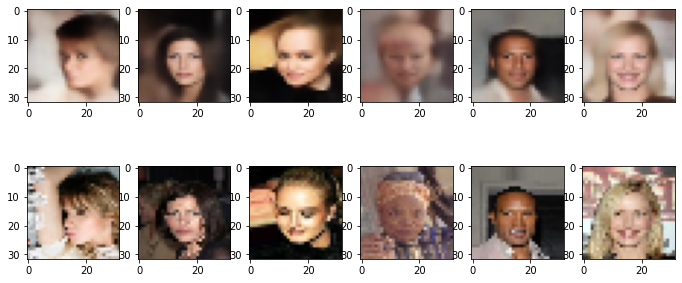

In [29]:
fig, axes = plt.subplots(2,6)
fig.subplots_adjust(0,0,1.5,1)

test_idxs = [0,1,2,3,4,5]
preds = vae.predict(test[test_idxs])

for i, pred in enumerate(preds):
    axes[0][i].imshow(pred)
    axes[1][i].imshow(test[test_idxs[i]])

The predicted images (top row) are very smooth. Some of this will be due to the VAE - they tend to produce smooth images for unknown reasons (at the time off publishing of Goodfellow's Deep Learning), but likely further training or higher model capacity would improve performance.

Below, I plot the resulf of changing values in the mean vector generated by the encoder then putting the new mean and generated variance through the decoder. For each of the first 30 components in the mean, I ttry values between -10 and 10. While larger than values that will be generated by the encoder, it is only beyond these values that I found the images distorted beyond recognition.

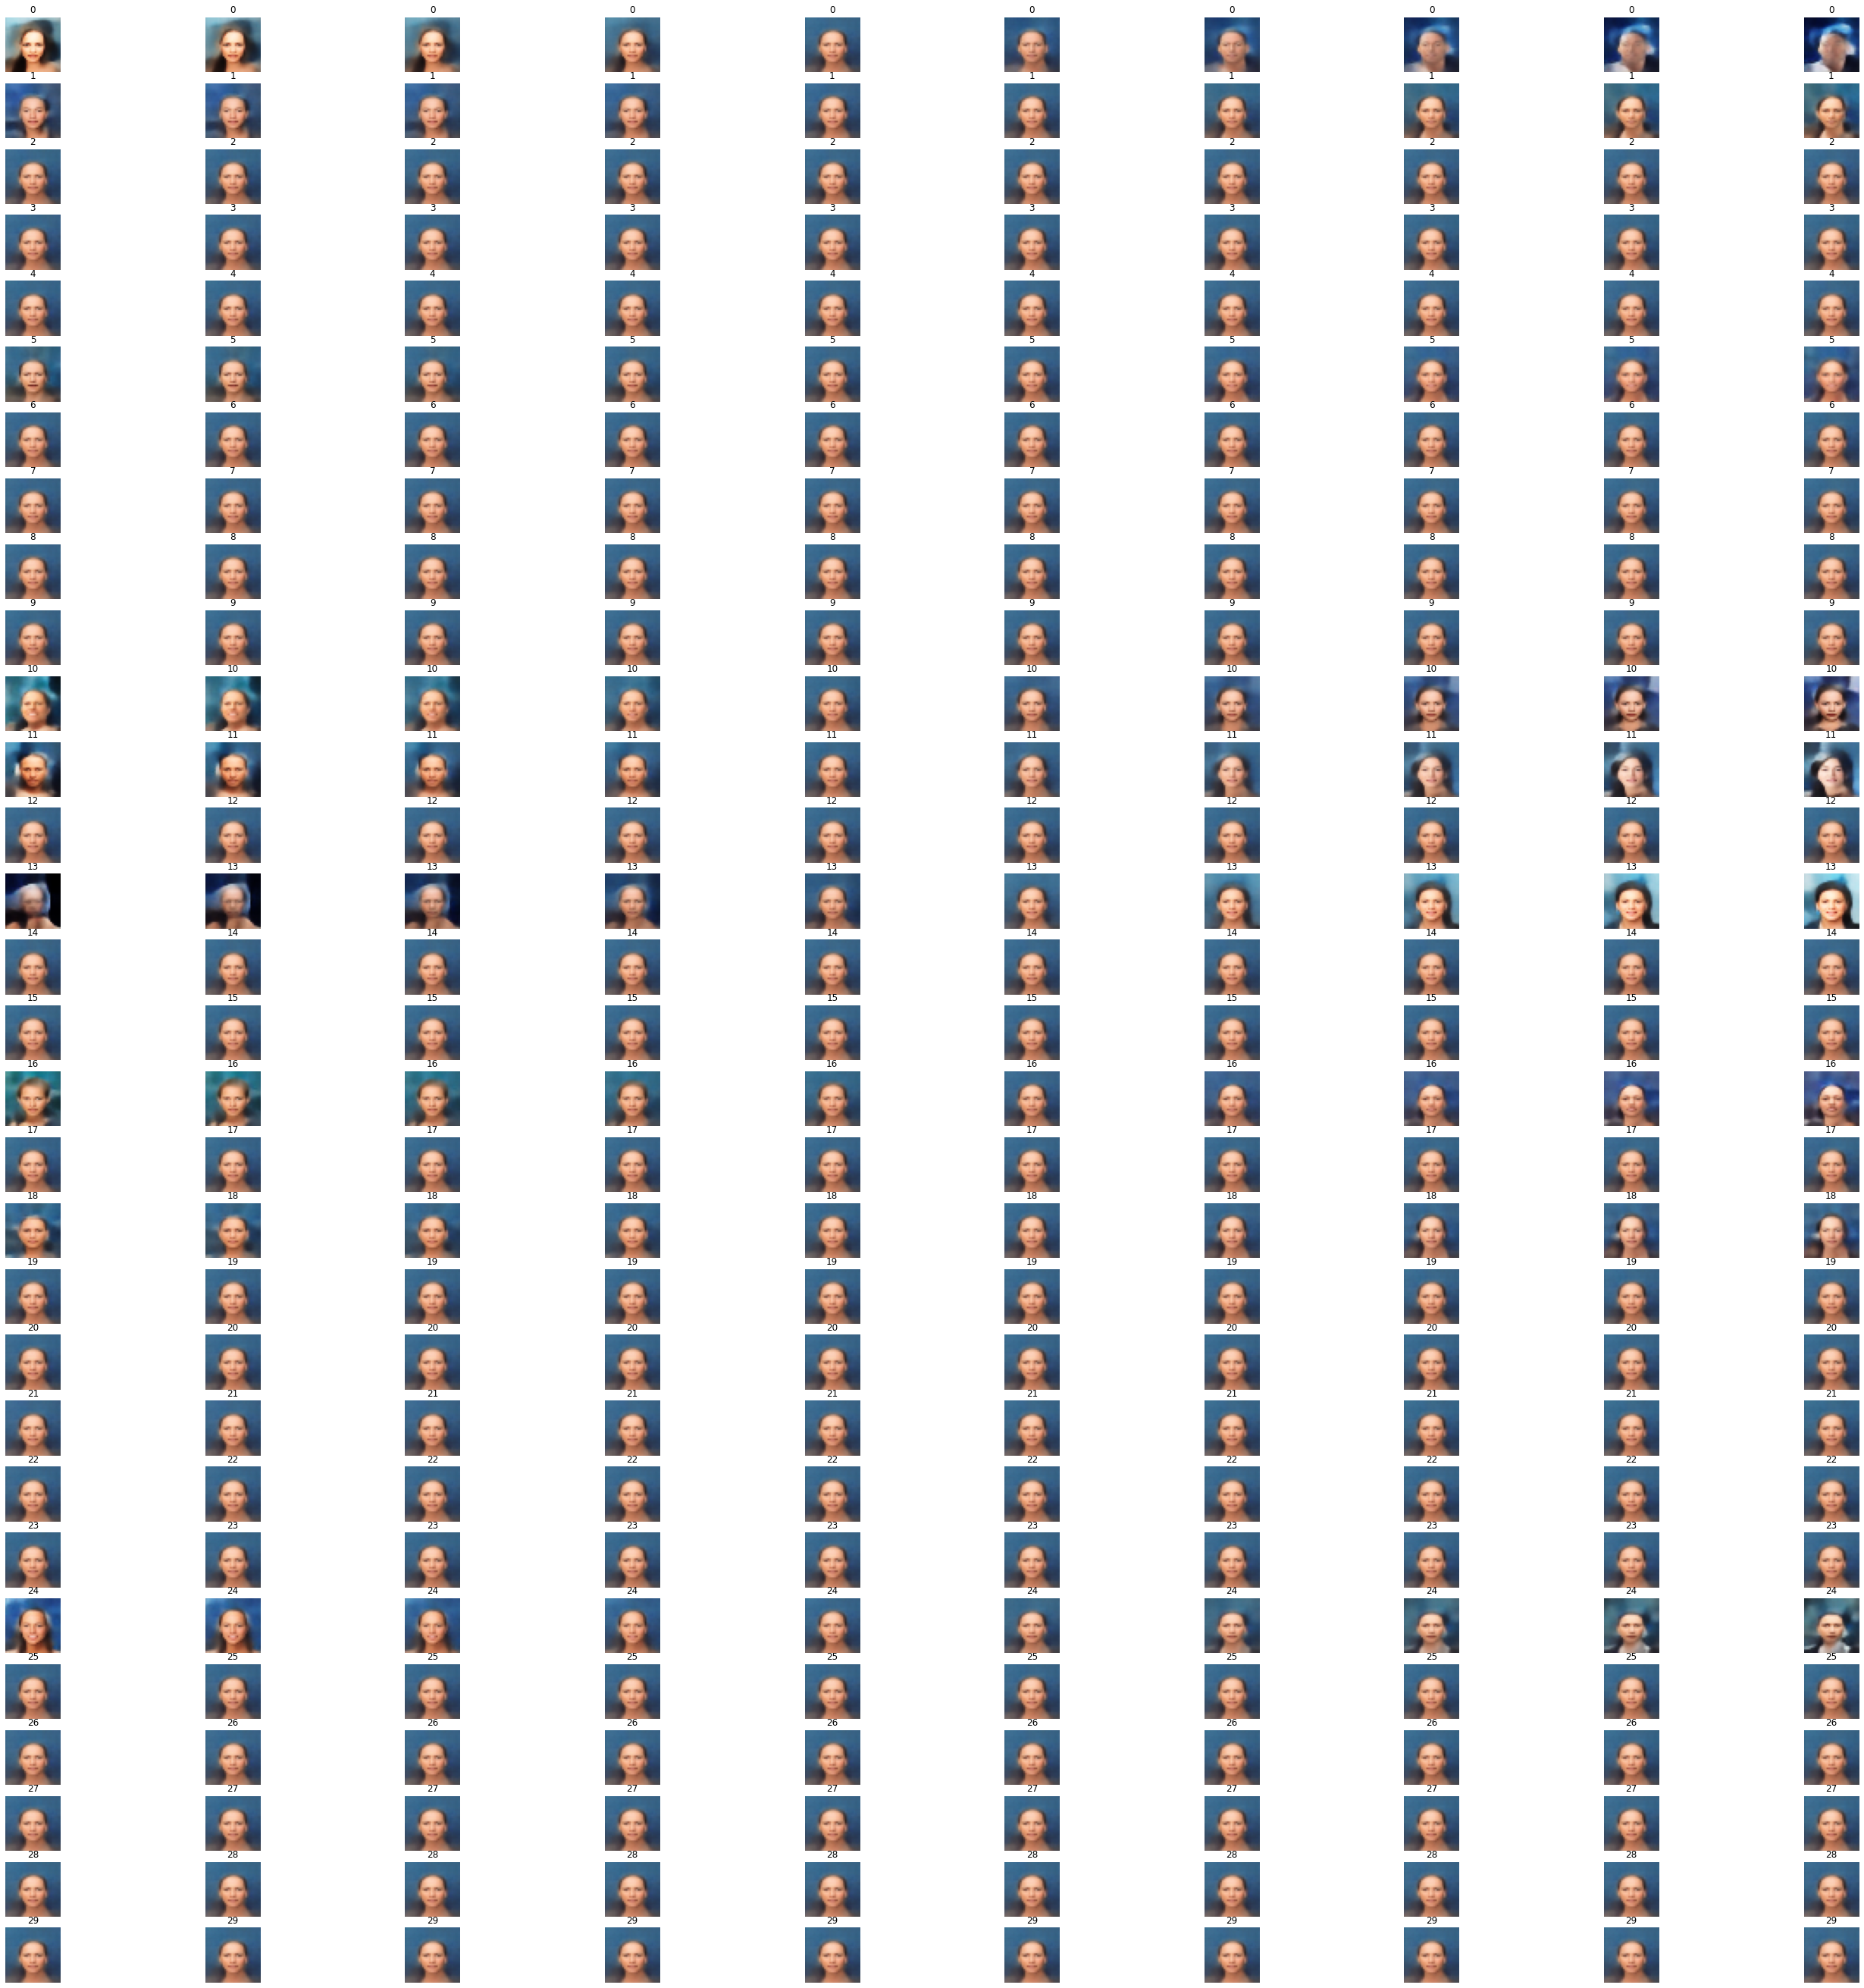

In [40]:
param_bound = 10
param_range = np.linspace(-param_bound,param_bound, 10)
components = 30

fig, axes = plt.subplots(components, len(param_range), figsize=(9,9))
fig.subplots_adjust(0,0,4,4)



for component in range(components):
    # Get image, latent mean and var, reconstructed image
    
    test_img = np.expand_dims(test[100], 0)    
    test_z_mean, test_log_z_var = vae.encoder(test_img)
    imgs_to_plot = []
    

    # Loop through parameter values
    for param_val in param_range:
        # Edit latent variable
        test_z_mean = tf.constant(test_z_mean).numpy()
        test_z_mean[0][component] = param_val
        img = vae.decoder(test_z_mean, test_log_z_var)
        imgs_to_plot.append(np.squeeze(img))

    for j, img in enumerate(imgs_to_plot):
        axes[component][j].imshow(img)
        axes[component][j].margins(x=0, y=0)
        axes[component][j].axis('off')
        axes[component][j].set_title(component)
        

Some of these components have interesting effects. The 0th, for example, may point in the direction of masculinity/femininity. The 11th affects hair. Notably, not all components seem to have any effect, and not all vectors with an effect seemed to affect all images. The former I assumed meant I picked a latent dimension that was too high, but I did not have any success with a lower dimension. The latter I attributed to insufficient training, but as of pushing, I have not found any learning rate schedule and combination of other hyperparameters that gets the model below a plateau of around 505 reconstruction loss.

Another thing we can attempt is to generate images.

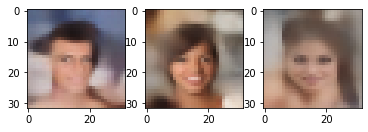

In [54]:
num_examples = 3
fig, axes = plt.subplots(1, num_examples)

z_mean = tf.random.normal((num_examples, latent_dim))
z_log_var = tf.random.normal((num_examples, latent_dim))

preds = vae.decoder(z_mean, z_log_var)

for i in range(num_examples):
    axes[i].imshow(tf.squeeze(preds[i]))

Predictions variation in quality. Some are decent, others are not recognizably human, and some have the vague fuzziness of a clearly very undertrained VAE.